# Importations

In [1]:
from sklearn.metrics import mean_squared_error
import gc
from scipy import sparse

In [2]:
import math

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from numpy import save

# Read Data

In [4]:
bookmarks = pd.read_csv("./recommendation/bookmarks.csv")
#assets = pd.read_csv("../recommendations/assets.csv", index_col=0)
#assets_genres = pd.read_csv("../recommendations/asset_genres.csv")
favorites = pd.read_csv("./recommendation/favorites.csv")
#genres = pd.read_csv("../recommendations/genres.csv")
ratings = pd.read_csv("./recommendation/ratings.csv")

In [5]:
bookmarks.head()

,id_profile,id_asset,time
0,10,24016,0
1,10,24042,0
2,10,24130,0
3,10,24250,0
4,10,24359,19000


In [6]:
ratings.head()

,id_profile,score,time,id_asset
0,581352,5.0,1555296701000,23568
1,1043474,5.0,1539800341000,385428
2,420488,3.5,1518482338000,26464
3,1277812,5.0,1565056946000,443500
4,327953,5.0,1508631887000,34243


In [7]:
favorites.head()

,id_profile,id_asset,added_date
0,144,1486,1567660088461
1,144,374333,1567660088461
2,144,443500,1567660088461
3,2367,24056,1567660088461
4,2472,24152,1567660088461


# Compute Interests

In [8]:
def interest_generator(bookmarks, ratings, favorites):
    bookmarks = bookmarks.merge(ratings.drop("time", axis=1), on=['id_profile', 'id_asset'], how = "outer")\
                         .merge(favorites, on=['id_profile', 'id_asset'], how = "outer")\
                         .fillna(0)
    
    ratings = None
    del ratings
    gc.collect()
    
    favorites = None
    del favorites
    gc.collect()
    
    bookmarks["w"] = bookmarks["time"].apply(lambda x : 1 if x>0 else 0)
    bookmarks["f"] = bookmarks["added_date"].apply(lambda x : 5 if x>0 else 0)
    bookmarks["interest"] = bookmarks["score"] + bookmarks["f"] + bookmarks["w"]
    return bookmarks[["id_profile", "id_asset", "interest"]]

In [9]:
bookmarks = interest_generator(bookmarks, ratings, favorites)

In [10]:
bookmarks.head()

,id_profile,id_asset,interest
0,10,24016,0.0
1,10,24042,0.0
2,10,24130,0.0
3,10,24250,0.0
4,10,24359,1.0


In [12]:
train = np.load('./recommendation/bookmarks_idx_train.npy')
test = np.load('./recommendation/bookmarks_idx_test.npy')

In [13]:
train_set = bookmarks.iloc[train].drop_duplicates(subset=['id_profile', 'id_asset'])
train = None
gc.collect()
del train

test_set = bookmarks.iloc[test].drop_duplicates(subset=['id_profile', 'id_asset'])
test = None
gc.collect()
del test

bookmarks = None
gc.collect()
del bookmarks

# SVD++

In [14]:
gc.collect()

20

Approche non Vectorisée

In [15]:
from random import random

In [17]:
f = 50

In [18]:
#train_set.sort_values(by=["id_profile"], inplace=True)

In [19]:
train_set.head()

,id_profile,id_asset,interest
39963458,326534,202094,0.0
41808284,133318,5343689,0.0
37973227,1101174,86739,1.0
43528603,1264136,5349884,0.0
9434040,1093487,1547,0.0


In [20]:
mu = np.mean(train_set.interest.values)

In [21]:
train_set = train_set[train_set.interest > 0]

In [22]:
unique_assets_train = pd.unique(train_set.id_asset)
unique_profiles_train = pd.unique(train_set.id_profile)

number_of_films = len(unique_assets_train)
number_of_users = len(unique_profiles_train)

In [23]:
group = train_set[train_set.interest > 0].groupby("id_profile")
Nu = group['id_asset'].apply(list)
Nu_count = group['id_asset'].count()

group = None
del group
gc.collect()

0

In [24]:
hashmap_u_to_index = {j:i for i,j in enumerate(unique_profiles_train)}
hashmap_i_to_index = {j:i for i,j in enumerate(unique_assets_train)}

In [25]:
unique_profiles_train = None
del unique_profiles_train
gc.collect()

unique_assets_train = None
del unique_assets_train
gc.collect()

0

In [26]:
bu = np.random.randn(number_of_users)
bi = np.random.randn(number_of_films)

qi = np.random.randn(number_of_films, f)
pu = np.random.randn(number_of_users, f)
yi = np.random.randn(number_of_films, f)

In [27]:
num_chunks = 10
all_chunks = [sparse.coo_matrix((df_subset.interest.values, (df_subset.id_profile.values, df_subset.id_asset.values))) for df_subset in np.array_split(train_set, num_chunks)] 

In [28]:
rui = sparse.coo_matrix((train_set.interest.values, (train_set.id_profile.values, train_set.id_asset.values)))

In [29]:
train_set = None
gc.collect()
del train_set

In [30]:
def dict_values_to_array(d):
    return np.array(list(d.values()))

def calculer_sum_yj(Nu, yi, u):
    return np.sum(yi[[hashmap_i_to_index[ii] for ii in \
                      Nu[u]]], axis=0)

def calculer_rui_chapeau(mu, bu, bi, qi, pu, Nu, Nu_count, yi, u, i, u_index, i_index):
    yj = calculer_sum_yj(Nu, yi, u)
    rui_chapeau =  mu + \
                   bu[u_index] + \
                   bi[i_index] + \
                   np.dot(qi[i_index].T, pu[u_index] + \
                   (1/np.sqrt(Nu_count[u]))* \
                   yj)
    return rui_chapeau

def calculer_cost(rui, mu, bu, bi, qi, pu, Nu, Nu_count, yi, gamma=0.007, lambda6=0.005, lambda7=0.015):
    cost = 0
    for u, i, rui_u_i in tqdm(zip(rui.row, rui.col, rui.data), total=len(rui.data)):
        u_index = hashmap_u_to_index[u]
        i_index = hashmap_i_to_index[i]
        
        cost += np.power(rui_u_i - calculer_rui_chapeau(mu, bu, bi, qi, pu, Nu, Nu_count, yi, u, i, u_index, i_index), 2)
    cost += lambda6*(np.sum(np.power(dict_values_to_array(bi), 2)) + np.sum(np.power(dict_values_to_array(bu), 2)))
    cost += lambda7*(np.sum(np.power(dict_values_to_array(qi), 2)) + np.sum(np.power(dict_values_to_array(pu), 2)) + np.sum(np.power(dict_values_to_array(yi), 2)))
    return cost

def estimer_parametres(rui, mu, bu, bi, qi, pu, Nu, Nu_count, yi, gamma=0.007, lambda6=0.005, lambda7=0.015):
    rmse = 0
    for u, i, rui_u_i in tqdm(zip(rui.row, rui.col, rui.data), total=len(rui.data)):
        u_index = hashmap_u_to_index[u]
        i_index = hashmap_i_to_index[i]
        
        diff = rui_u_i - calculer_rui_chapeau(mu, bu, bi, qi, pu, Nu, Nu_count, yi, u, i, u_index, i_index)
        rmse += diff**2
        
        bu[u_index] += gamma * (diff - lambda6*bu[u_index])
        pu[u_index] += gamma * (np.multiply(diff, qi[i_index]) - lambda7*pu[u_index])
        
        bi[i_index] += gamma*(diff - lambda6*bi[i_index])
        qi[i_index] += gamma*(np.multiply(diff, (pu[u_index] + (1/np.sqrt(Nu_count[u]))*calculer_sum_yj(Nu, yi, u))) - lambda7*qi[i_index])
        yi[i_index] += gamma*(np.multiply(diff, (1/np.sqrt(Nu_count[u]))*qi[i_index]) - lambda7*yi[i_index])
    return np.sqrt(rmse/len(rui.data))

In [31]:
lambda6 = 0.005
lambda7 = 0.015
epochs = 20
gamma = 0.007

def train_process(rui_chunk, gamma):
    rmse_list = list()
    for epoch in range(1, epochs+1):
        rmse = estimer_parametres(rui_chunk, 
                                   mu, 
                                   bu, 
                                   bi, 
                                   qi, 
                                   pu, 
                                   Nu, 
                                   Nu_count, 
                                   yi,
                                   gamma = gamma)

        rmse_list.append(rmse)
        gc.collect()
        gamma *= 0.9
    return rmse_list

In [32]:
rmse_list_list = list()
for i, rui_chunk in enumerate(all_chunks):
    print("Chunk {} started".format(i))
    rmse_list_list.append(train_process(rui_chunk, gamma))
    np.save('./bu.npy', bu)
    np.save('./bi.npy', bi)
    np.save('./pu.npy', pu)
    np.save('./qi.npy', qi)
    np.save('./yi.npy', yi)

  0%|          | 456/436361 [00:00<01:36, 4514.89it/s]

Chunk 0 started


  0%|          | 904/436361 [00:00<00:48, 9039.97it/s]

Chunk 1 started


  0%|          | 911/436361 [00:00<00:47, 9109.88it/s]

Chunk 2 started


  0%|          | 918/436361 [00:00<00:47, 9179.83it/s]

Chunk 3 started


  0%|          | 903/436361 [00:00<00:48, 8940.44it/s]

Chunk 4 started


  0%|          | 876/436361 [00:00<00:50, 8673.32it/s]

Chunk 5 started


  0%|          | 1834/436361 [00:00<00:47, 9124.70it/s]

Chunk 6 started


  0%|          | 1941/436361 [00:00<00:44, 9653.94it/s]

Chunk 7 started


  0%|          | 1923/436360 [00:00<00:45, 9570.03it/s]

Chunk 8 started


  0%|          | 923/436360 [00:00<00:47, 9229.90it/s]

Chunk 9 started


100%|██████████| 436360/436360 [00:46<00:00, 9338.50it/s]


Text(0, 0.5, 'RMSE')

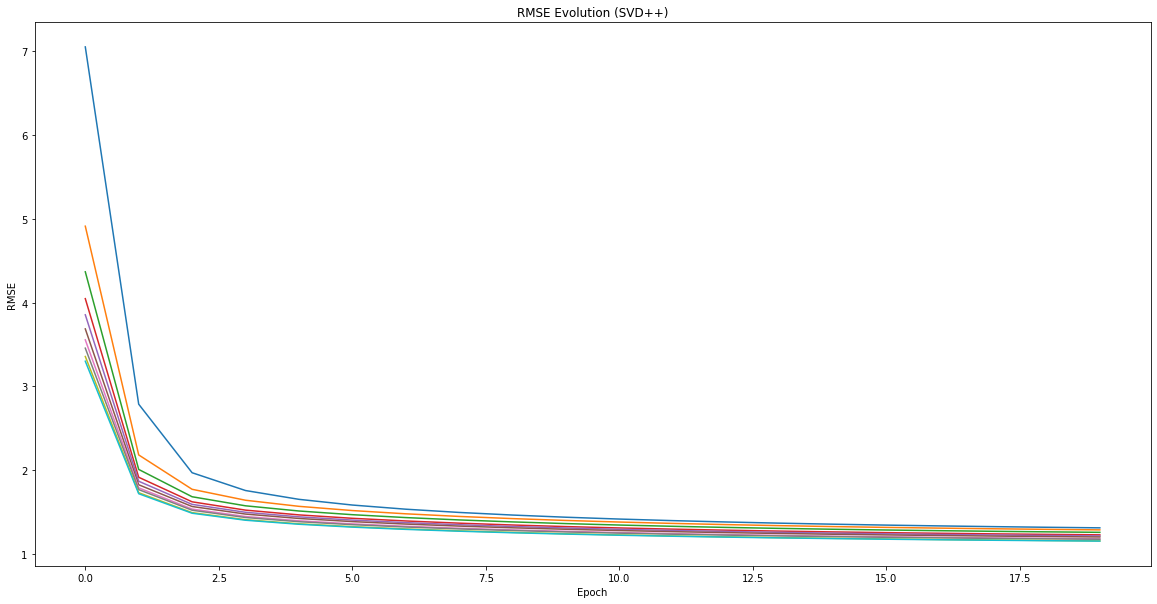

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))
for rmse_l in rmse_list_list:
    ax = plt.plot(rmse_l)
plt.title("RMSE Evolution (SVD++)")
plt.xlabel('Epoch')
plt.ylabel('RMSE')

In [34]:
np.save('./bu.npy', bu)
np.save('./bi.npy', bi)
np.save('./pu.npy', pu)
np.save('./qi.npy', qi)
np.save('./yi.npy', yi)

In [39]:
def predict_interest(u, i):
    u_index = hashmap_u_to_index[u]
    i_index = hashmap_i_to_index[i]
    
    pred = mu
    
    try:
        pred += bu[u]
    except KeyError:
        pass
        #print("User {} not found".format(u))
        
    try:
        pred += bi[i]
    except KeyError:
        pass
        #print("Film {} not found".format(i))
        
    try:
        pred = pred + calculer_rui_chapeau(mu, bu, bi, qi, pu, Nu, Nu_count, yi, u, i, u_index, i_index)
    except KeyError:
        pass
        #print("Film {} / User {} not found".format(i, u))
        
    return pred

In [40]:
test_set["predicted_interest"] = [predict_interest(u, i) for u,i in zip(test_set.id_profile.values, test_set.id_asset.values)]

IndexError: index 1045347 is out of bounds for axis 0 with size 636390

In [ ]:
test_set.head(50)

In [ ]:
mean_squared_error(test_set.interest.values, test_set.predicted_interest.values)